# **IMPORTING NECESSARY LIBRARIES**

In [1]:
import os
import numpy as np
import pandas as pd
import random
# importing libraries related to keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle




In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##  LOAD DATASET

In [3]:
train_dir = '/content/drive/MyDrive/MRImages/Training'
test_dir = '/content/drive/MyDrive/MRImages/Testing'

# shuffle train data to avoid overfitting and bias
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image_file in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image_file))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)
train_paths

['/content/drive/MyDrive/MRImages/Training/pituitary/Tr-pi_0304.jpg',
 '/content/drive/MyDrive/MRImages/Training/pituitary/Tr-pi_0672.jpg',
 '/content/drive/MyDrive/MRImages/Training/glioma/Tr-gl_0291.jpg',
 '/content/drive/MyDrive/MRImages/Training/glioma/Tr-gl_0534.jpg',
 '/content/drive/MyDrive/MRImages/Training/meningioma/Tr-me_0083.jpg',
 '/content/drive/MyDrive/MRImages/Training/notumor/Tr-no_0491.jpg',
 '/content/drive/MyDrive/MRImages/Training/meningioma/Tr-me_0654.jpg',
 '/content/drive/MyDrive/MRImages/Training/pituitary/Tr-pi_0948.jpg',
 '/content/drive/MyDrive/MRImages/Training/pituitary/Tr-pi_0787.jpg',
 '/content/drive/MyDrive/MRImages/Training/meningioma/Tr-me_0947.jpg',
 '/content/drive/MyDrive/MRImages/Training/meningioma/Tr-me_0117.jpg',
 '/content/drive/MyDrive/MRImages/Training/glioma/Tr-gl_1305.jpg',
 '/content/drive/MyDrive/MRImages/Training/meningioma/Tr-me_0435.jpg',
 '/content/drive/MyDrive/MRImages/Training/glioma/Tr-gl_0616.jpg',
 '/content/drive/MyDrive/MRIm

In [4]:
# same for test data - load and shuffle
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image_file in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image_file))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)
test_paths



['/content/drive/MyDrive/MRImages/Testing/notumor/Te-no_0235.jpg',
 '/content/drive/MyDrive/MRImages/Testing/pituitary/Te-pi_0225.jpg',
 '/content/drive/MyDrive/MRImages/Testing/glioma/Te-gl_0138.jpg',
 '/content/drive/MyDrive/MRImages/Testing/meningioma/Te-me_0131.jpg',
 '/content/drive/MyDrive/MRImages/Testing/notumor/Te-no_0301.jpg',
 '/content/drive/MyDrive/MRImages/Testing/meningioma/Te-me_0176.jpg',
 '/content/drive/MyDrive/MRImages/Testing/pituitary/Te-pi_0159.jpg',
 '/content/drive/MyDrive/MRImages/Testing/notumor/Te-no_0060.jpg',
 '/content/drive/MyDrive/MRImages/Testing/meningioma/Te-me_0230.jpg',
 '/content/drive/MyDrive/MRImages/Testing/meningioma/Te-me_0157.jpg',
 '/content/drive/MyDrive/MRImages/Testing/pituitary/Te-pi_0258.jpg',
 '/content/drive/MyDrive/MRImages/Testing/pituitary/Te-pi_0204.jpg',
 '/content/drive/MyDrive/MRImages/Testing/pituitary/Te-pi_0266.jpg',
 '/content/drive/MyDrive/MRImages/Testing/notumor/Te-no_0012.jpg',
 '/content/drive/MyDrive/MRImages/Testing

# **DATA VISUALIZATION**

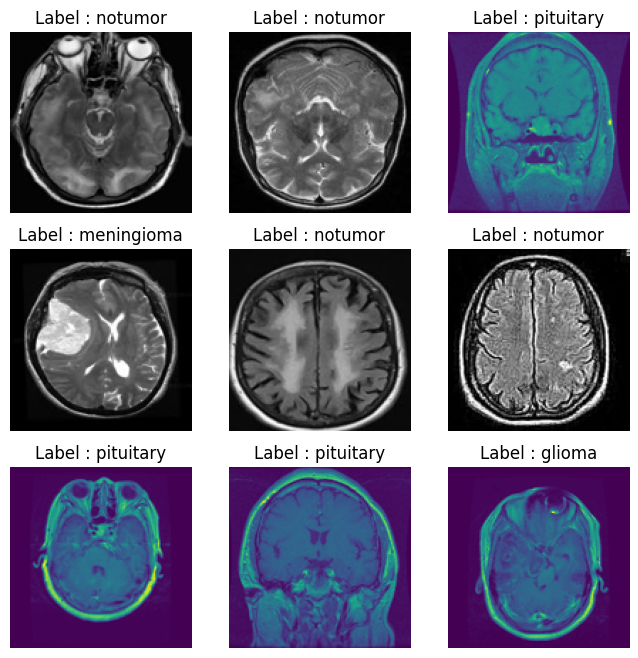

In [5]:
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
# select random images to visulaize
random_indices  = random.sample(range(len(train_paths)), 9)

# display
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
axes = axes.ravel()

for i, indx in enumerate(random_indices):
    img_path = train_paths[indx]
    img = Image.open(img_path)
    img = img.resize((128, 128))
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"Label : {train_labels[indx]}")

# **IMAGE PREPROCESSING**

In [6]:
# Image Augumentation function

def augument_image(image):
  image = Image.fromarray(np.uint8(image))
  image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
  image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
  image = np.array(image)/255.0
  return image
# Load Images and apply augumentation

def open_image(paths):
  images = []
  for path in paths:
    img = load_img(path, target_size = (IMAGE_SIZE, IMAGE_SIZE))
    # img = np.array(img)
    img = augument_image(img)
    images.append(img)
  return np.array(images)
# encoding labels i.e classes

def encode_label(labels):
  unique_labels = os.listdir(train_dir)
  encoded = [unique_labels.index(label) for label in labels]
  return np.array(encoded)

# data generator for batches

def data_generator(paths, labels, batch_size = 12, epochs = 1):
  for _ in range(epochs):
    for i in range(0, len(paths), batch_size):
      batch_paths = paths[i: i+batch_size]
      batch_images = open_image(batch_paths)
      batch_labels = labels[i:i+batch_size]
      batch_labels = encode_label(batch_labels)
      yield batch_images, batch_labels

# **MODEL BUILDING**

In [ ]:
train_length = os.listdir(train_dir)
train_length

['pituitary', 'glioma', 'meningioma', 'notumor']

In [7]:
# building a model using transfer learning - VGG16

# model architecture -- VGG16
IMAGE_SIZE = 128
base_model = VGG16(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights = 'imagenet')

# Freeze all layers of base model
for layer in base_model.layers:
  layer.trainable = False

# unfreeze layers that provide pretrained knowledge
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

# Building the model

model = Sequential()
model.add(Input(shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))

model.add(Dense(218, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(4, activation='softmax'))


# compiling the model
model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])

# parameters
batch_size = 20
steps = int(len(train_paths)/batch_size)
epochs = 10

# model training
history = model.fit(data_generator(train_paths, train_labels, batch_size=batch_size, epochs = epochs), epochs = epochs, steps_per_epoch = steps)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 2956s 10s/step - loss: 0.6239 - sparse_categorical_accuracy: 0.7424
Epoch 2/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 42s 105ms/step - loss: 0.2369 - sparse_categorical_accuracy: 0.9110
Epoch 3/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.1490 - sparse_categorical_accuracy: 0.9483
Epoch 4/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 32s 111ms/step - loss: 0.1119 - sparse_categorical_accuracy: 0.9600
Epoch 5/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - loss: 0.0782 - sparse_categorical_accuracy: 0.9678
Epoch 6/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - loss: 0.0603 - sparse_categorical_accuracy: 0.9792
Epoch 7/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - loss: 0.0593 - sparse_categorical_accuracy: 0.9821
Epoch 8/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 30s 106ms/step - loss: 0.0378 - sparse_categorical_accuracy: 0.9871
Epoch 9/10
285/285 ━━━━━━━━━━━━━━━━━━━━ 30s 107ms/step - loss: 0.0371 - sparse_catego

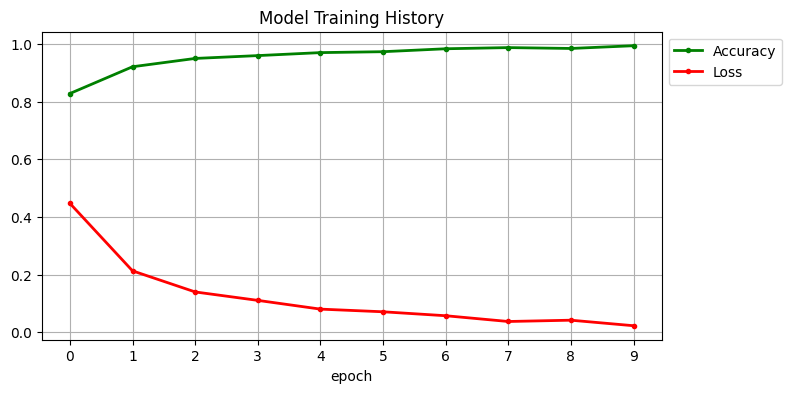

In [8]:
plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history.history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

In [14]:
test_images = open_image(test_paths)
test_labels = encode_label(test_labels)
test_predictions = model.predict(test_images)


41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 239ms/step


In [15]:
print("Classification report:")
print(classification_report(test_labels, np.argmax(test_predictions, axis = 1)))

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       300
           1       0.98      0.95      0.97       300
           2       0.95      0.94      0.94       306
           3       1.00      1.00      1.00       405

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



In [17]:
conf_matrix = confusion_matrix(test_labels, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[298   0   2   0]
 [  0 286  14   0]
 [ 11   5 288   2]
 [  0   0   0 405]]


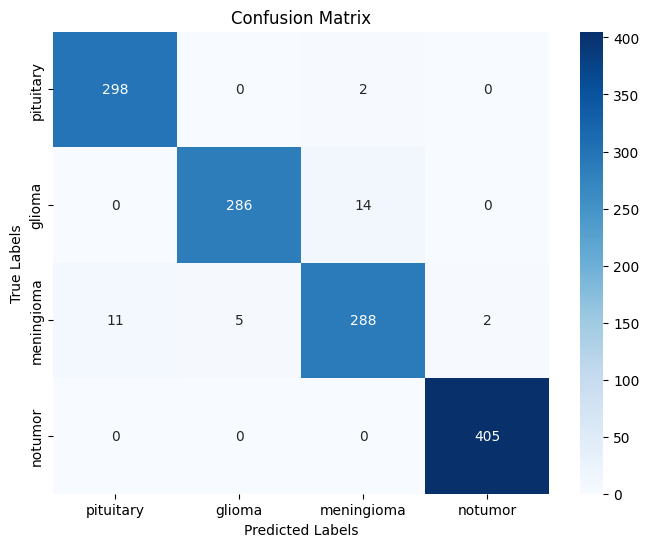

In [18]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

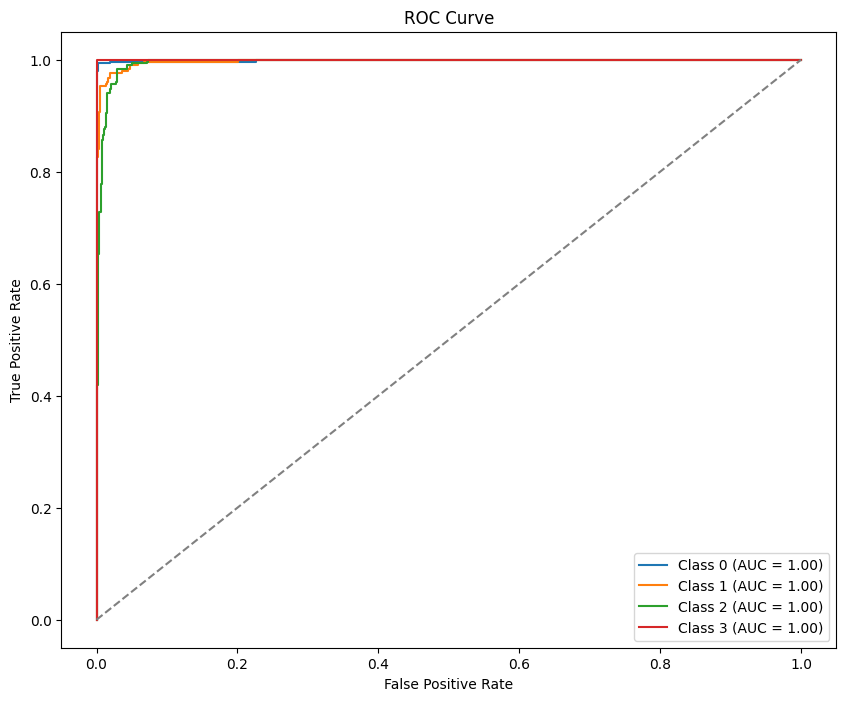

In [20]:
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [21]:
# Save the entire model
model.save('tumormodel.keras')

In [22]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('tumormodel.keras')

In [24]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

# Class labels
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, image_size=128):
    """
    Function to detect tumor and display results.
    If no tumor is detected, it displays "No Tumor".
    Otherwise, it shows the predicted tumor class and confidence.
    """
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"
        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


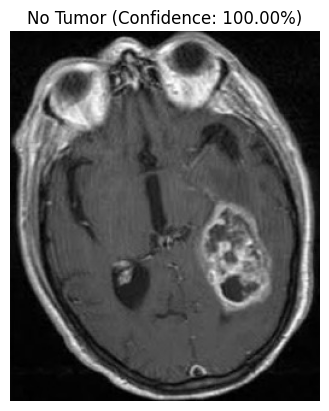

In [26]:
# Example usage
image_path = '/content/drive/MyDrive/MRImages/Testing/meningioma/Te-meTr_0001.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


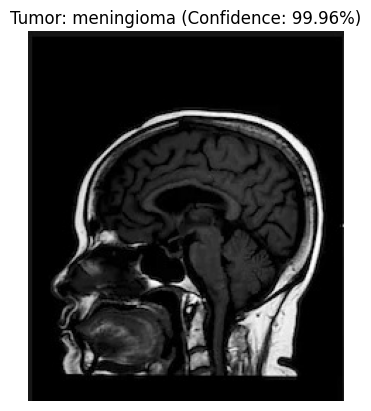

In [27]:
# Example usage
image_path = '/content/drive/MyDrive/MRImages/Testing/notumor/Te-noTr_0004.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step


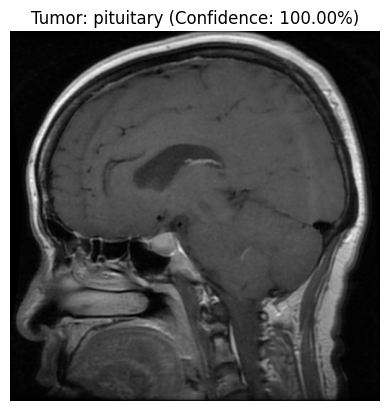

In [28]:
# Example usage
image_path = '/content/drive/MyDrive/MRImages/Testing/pituitary/Te-piTr_0003.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


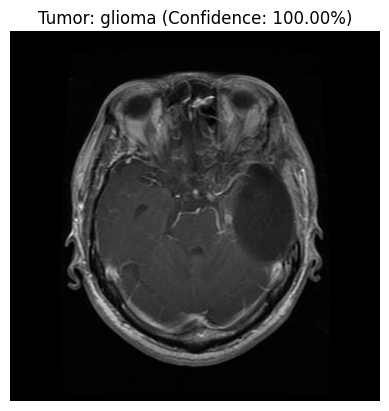

In [30]:
# Example usage
image_path = '/content/drive/MyDrive/MRImages/Testing/glioma/Te-gl_0015.jpg'  # Provide the path to your new image
detect_and_display(image_path, model)